In [338]:
%matplotlib inline

In [10]:
%%timeit -n1 -r1
import dask.dataframe as dd
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import glob
import mpld3
import fastparquet as fp
##
#   NaN is not supported in integer datatype
#   so for all the time-like fields,
#   they are defined as np.float64
#   string -> np.str_, single/double digits # -> np.float16, other number -> np.float32
##
DType = {
"QDate":np.float64,
"Project":np.str_,
"Owner":np.str_,
"VMInstanceType":np.str_,
"VMInstanceName":np.str_,
"VMSpec.RAM":np.float64,
"VMSpec.DISK":np.float64,
"VMSpec.CPU":np.float64,
"RequestMemory":np.float64,
"RequestDisk":np.float64,
"MemoryUsage":np.float64,
"DiskUsage":np.float64,
"JobStatus":np.float64,
"CommittedTime":np.float64,
"CommittedSuspensionTime":np.float64,
"CumulativeSlotTime":np.float64,
"NumJobStarts":np.int64,
"RequestCpus":np.float64,
"JobStartDate":np.float64,
"VMName":np.str_,
"RemoveReason":np.str_,
"CompletionDate":np.float64,
"ClusterId":np.float64,
"ProcId":np.float64,
"ClusterId":np.float64    
}

df = dd.read_csv("/data/condor/history.*.csv", dtype = DType).compute()
#fp.write('gzip.parq', df, compression = "GZIP")
#fp.write('uncompressed.parq', df)

1 loop, best of 1: 40 s per loop


In [7]:
%%timeit -n1 -r1
from fastparquet import ParquetFile
pf = ParquetFile('gzip.parq')
df = pf.to_pandas()

1 loop, best of 1: 33.7 s per loop


In [13]:
%%timeit -n1 -r1
from fastparquet import ParquetFile
pf2 = ParquetFile('uncompressed.parq')
df2 = pf2.to_pandas()

1 loop, best of 1: 21.1 s per loop


In [279]:
#%%timeit -n1 -r1
df_NumRes = df[["QDate","NumJobStarts"]]
df_NumRes = df_NumRes.assign(timestamp = df_NumRes.QDate.astype('datetime64[ms]'))

tmp = []
tmp.append(df_NumRes[df_NumRes["NumJobStarts"] == 0].assign(St = "never"))
tmp.append(df_NumRes[df_NumRes["NumJobStarts"] == 1].assign(St = "once"))
tmp.append(df_NumRes[(df_NumRes["NumJobStarts"] <= 5) & (df_NumRes["NumJobStarts"] > 1)].assign(St = "2~5"))
tmp.append(df_NumRes[df_NumRes["NumJobStarts"] > 5].assign(St = ">5"))

df_NumRes = pd.DataFrame()
for x in tmp: df_NumRes = df_NumRes.append(x, ignore_index = True)
    
del tmp

# stats:
# using the below code, ~8s for 2014 data
# using the above code, 400ms
# improved ~ 20 times
#
# def tmp(x):
#     #print(x)
#     if x["NumJobStarts"] == 0: return "never"
#     elif x["NumJobStarts"] == 1: return "once"
#     elif x["NumJobStarts"] < 10: return "1~10"
#     elif x["NumJobStarts"] < 100: return "10~100"
#     elif x["NumJobStarts"] < 1000: return "100~1000"
#     else: return ">1000"
#
# df_NumRes = df_NumRes.assign(St = df_NumRes.apply(lambda row: tmp(row), axis = 1))

df_NumRes = df_NumRes.set_index("timestamp")
fig = plt.figure(figsize=(10, 8))
tmp = df_NumRes[df_NumRes.St == "never"]
tmp = tmp.QDate.groupby(tmp.index.year).count().apply(np.sqrt)
#print("never\n", tmp)
ax = tmp.plot(kind = "bar", legend = False, width = 0.2, position = 2)
tmp = df_NumRes[df_NumRes.St == "once"]
tmp = tmp.QDate.groupby(tmp.index.year).count().apply(np.sqrt)
#print("once\n",tmp)
tmp.plot(kind = "bar", legend = False, width = 0.2, color = "purple", position = 1, ax = ax)
tmp = df_NumRes[df_NumRes.St == "2~5"]
tmp = tmp.QDate.groupby(tmp.index.year).count().apply(np.sqrt)
#print("2~5\n",tmp)
tmp.plot(kind = "bar", legend = False, width = 0.2, color = "orange", position = 0, ax = ax)
tmp = df_NumRes[df_NumRes.St == ">5"]
tmp = tmp.QDate.groupby(tmp.index.year).count().apply(np.sqrt)
tmp = pd.Series(0, index = [2010]).append(tmp)
#print(">5\n",tmp)
tmp.plot(kind = "bar", legend = False, width = 0.2, color = "green", position = -1, ax = ax)
del tmp

# df_NumRes = df_NumRes.groupby(df_NumRes.index).count().reindex(index = ["never","once","2~5",">5"])\
#             .apply(np.sqrt)
# print(df_NumRes)
# ## plot
# fig = plt.figure(figsize=(10,8))
# ax = df_NumRes["NumJobStarts"].plot(kind = "bar", legend = False)
ax_yticks = [0.1, 0.5, 1, 2, 4]
ax.set_yticks([x for x in np.sqrt([y * 1000000 for y in ax_yticks])])
ax.set_yticklabels([str(x) for x in ax_yticks])
ax.set_title("Batch Processing Job Restarts", size = "xx-large")
#ax.set_xlabel("Year", size = "large")
ax.set_ylabel("Number of jobs (millions)", size = "large")
ax.legend(["never", "once", "2~5", ">5"], loc = 2)
#mpld3.display()
fig.savefig("BatchJobRestarts.png")
mpld3.display()

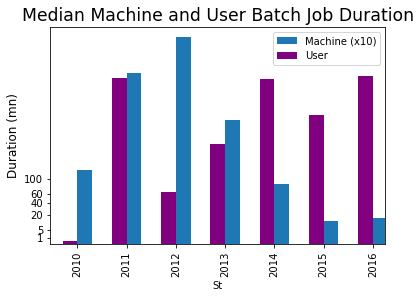

In [280]:
df_JobDur = df[["CompletionDate", "JobStartDate", "QDate", "JobStatus"]].dropna(how = "any", subset = ["JobStartDate"])
df_JobDur = df_JobDur[(df_JobDur["JobStatus"] == 4)][["CompletionDate", "JobStartDate", "QDate"]]
df_TotDur = df_JobDur[["CompletionDate", "QDate"]]
# print(len(df_JobDur))
# print(len(df_TotDur))
# df_JobDur["JobDuration"] = (df_JobDur["CompletionDate"] - df_JobDur["JobStartDate"]).fillna(value=0)
# df_TotDur["TotDuration"] = (df_TotDur["CompletionDate"] - df_TotDur["QDate"] / 1000).fillna(value=0)
# two above new column assignment will have unpredictable results. use .assign() instead!
df_JobDur = df_JobDur.assign(JobDuration = (df_JobDur["CompletionDate"].astype(np.int64) - df_JobDur["JobStartDate"].astype(np.int64)).fillna(value=0))
df_TotDur = df_TotDur.assign(TotDuration = (df_TotDur["CompletionDate"].astype(np.int64) - np.dot(df_TotDur["QDate"], 1/1000).astype(np.int64)).fillna(value=0))
# print(len(df_JobDur))
# print(len(df_TotDur))
df_JobDur = df_JobDur[df_JobDur["JobDuration"] >= 0]
df_TotDur = df_TotDur[df_TotDur["TotDuration"] >= 0]
# df_Ratio = pd.concat([(df_JobDur["JobDuration"] / df_TotDur["TotDuration"]), df_JobDur["QDate"]], axis = 1)
# print(df_Ratio)
# df_Ratio = df_Ratio.assign(timestamp = df_Ratio.QDate.astype('datetime64[ms]'))
# df_Ratio = df_Ratio.set_index("timestamp")
# grped_Ratio = df_Ratio.groupby(df_Ratio.index.year)
# print(len(df_JobDur))
# print(len(df_TotDur))

# test = df_JobDur["JobDuration"].astype("int64").value_counts(sort = False)
# fig = plt.figure(figsize = (10, 10))
# ax = plt.hist(np.dot(df_JobDur["JobDuration"].values.tolist(), 1/3600), bins = 200, range = (0, 1000), histtype = "step", log = True)
# plt.hist(np.dot(df_TotDur["TotDuration"].values.tolist(), 1/3600), bins = 200, range = (0, 1000), histtype = "step", log = True)

# def tmp2(row, label):
#     if row[label] < 10: return "<10s"
#     elif row[label] < 60: return "10s~1m"
#     elif row[label] < 600: return "1m~10m"
#     elif row[label] < 3600: return "10m~1h"
#     elif row[label] < 36000: return "1h~10h"
#     else: return ">10h"
    
#print("where is the warning msg?")
#df_JobDur["timestamp"] = df_JobDur.QDate.astype('datetime64[ms]')
df_JobDur = df_JobDur.assign(timestamp = df_JobDur.QDate.astype('datetime64[ms]'))
#df_TotDur["timestamp"] = df_TotDur.QDate.astype('datetime64[ms]')
df_TotDur = df_TotDur.assign(timestamp = df_TotDur.QDate.astype('datetime64[ms]'))

tmp = []
tmp.append(df_JobDur[df_JobDur["JobDuration"] <= 10].assign(St = "<10s"))
tmp.append(df_JobDur[(df_JobDur["JobDuration"] <= 60) & (df_JobDur["JobDuration"] > 10)].assign(St = "10s~1m"))
tmp.append(df_JobDur[(df_JobDur["JobDuration"] <= 600) & (df_JobDur["JobDuration"] > 60)].assign(St = "1m~10m"))
tmp.append(df_JobDur[(df_JobDur["JobDuration"] <= 3600) & (df_JobDur["JobDuration"] > 600)].assign(St = "10m~1h"))
tmp.append(df_JobDur[(df_JobDur["JobDuration"] <= 18000) & (df_JobDur["JobDuration"] > 3600)].assign(St = "1h~5h"))
tmp.append(df_JobDur[(df_JobDur["JobDuration"] <= 36000) & (df_JobDur["JobDuration"] > 18000)].assign(St = "5h~10h"))
tmp.append(df_JobDur[(df_JobDur["JobDuration"] <= 180000) & (df_JobDur["JobDuration"] > 36000)].assign(St = "10h~50h"))
tmp.append(df_JobDur[(df_JobDur["JobDuration"] <= 252000) & (df_JobDur["JobDuration"] > 180000)].assign(St = "50h~70h"))
tmp.append(df_JobDur[df_JobDur["JobDuration"] > 252000].assign(St = ">70h"))
df_JobDur = pd.DataFrame()
for x in tmp: df_JobDur = df_JobDur.append(x, ignore_index = True)

tmp = []
tmp.append(df_TotDur[df_TotDur["TotDuration"] <= 10].assign(St = "<10s"))
tmp.append(df_TotDur[(df_TotDur["TotDuration"] <= 60) & (df_TotDur["TotDuration"] > 10)].assign(St = "10s~1m"))
tmp.append(df_TotDur[(df_TotDur["TotDuration"] <= 600) & (df_TotDur["TotDuration"] > 60)].assign(St = "1m~10m"))
tmp.append(df_TotDur[(df_TotDur["TotDuration"] <= 3600) & (df_TotDur["TotDuration"] > 600)].assign(St = "10m~1h"))
tmp.append(df_TotDur[(df_TotDur["TotDuration"] <= 18000) & (df_TotDur["TotDuration"] > 3600)].assign(St = "1h~5h"))
tmp.append(df_TotDur[(df_TotDur["TotDuration"] <= 36000) & (df_TotDur["TotDuration"] > 18000)].assign(St = "5h~10h"))
tmp.append(df_TotDur[(df_TotDur["TotDuration"] <= 180000) & (df_TotDur["TotDuration"] > 36000)].assign(St = "10h~50h"))
tmp.append(df_TotDur[(df_TotDur["TotDuration"] <= 252000) & (df_TotDur["TotDuration"] > 180000)].assign(St = "50h~70h"))
tmp.append(df_TotDur[df_TotDur["TotDuration"] > 252000].assign(St = ">70h"))
df_TotDur = pd.DataFrame()
for x in tmp: df_TotDur = df_TotDur.append(x, ignore_index = True)
    
del tmp

# df_JobDur = df_JobDur.assign(St = (df_JobDur.apply(lambda row: tmp2(row, "JobDuration"), axis = 1)))
# df_TotDur = df_TotDur.assign(St = (df_TotDur.apply(lambda row: tmp2(row, "TotDuration"), axis = 1)))
df_JobDur = df_JobDur.set_index("St")
grped_JobDur = df_JobDur.groupby(df_JobDur.index).count()\
            .reindex(index = ["<10s","10s~1m", "1m~10m", "10m~1h", "1h~5h", "5h~10h", "10h~50h", "50h~70h", ">70h"])\
            .apply(np.sqrt)
df_TotDur = df_TotDur.set_index("St")
grped_TotDur = df_TotDur.groupby(df_TotDur.index).count()\
            .reindex(index = ["<10s","10s~1m", "1m~10m", "10m~1h", "1h~5h", "5h~10h", "10h~50h", "50h~70h", ">70h"])\
            .apply(np.sqrt)    
# print(grped_JobDur)
# print(grped_TotDur)
## plot
#fig = plt.figure(figsize=(10, 20))
#fig.add_subplot(211)
ax = grped_JobDur["JobDuration"].plot(kind = "bar", width = 0.3, position = 0)
grped_TotDur["TotDuration"].plot(kind = "bar", color = "purple", width = 0.3, position = 1, ax = ax)
ax_yticks = [0.1, 0.5, 1, 2, 4]
ax.set_yticks([x for x in np.sqrt(np.dot(ax_yticks, 1000000))])
ax.set_yticklabels([str(x) for x in ax_yticks])
ax.set_title("Batch Processing Jobs Machine and User Duration", size = "xx-large")
#ax.set_xlabel("Duration", size = "large")
ax.set_ylabel("Number of jobs (millions)", size = "large")
ax.legend(["Machine", "User"], loc = 2)

## 2nd plt
#fig.add_subplot(212)
## reindex by time
df_JobDur = df_JobDur.set_index("timestamp")
df_TotDur = df_TotDur.set_index("timestamp")
grped_JobDur = df_JobDur.groupby(df_JobDur.index.year).median()/60
grped_TotDur = df_TotDur.groupby(df_TotDur.index.year).median()/60
# print(grped_JobDur)
# print(grped_TotDur)
ax2 = (grped_JobDur["JobDuration"]*10).plot(kind = "bar", width = 0.3, position = 0)
grped_TotDur["TotDuration"].plot(kind = "bar", color = "purple", width = 0.3, position = 1, ax = ax2)
ax2.set_title("Median Machine and User Batch Job Duration", size = "xx-large")
#ax2.set_xlabel("Year", size = "large")
ax2.set_ylabel("Duration (mn)", size = "large")
#ax2.set_yticks([])
#ax2.yaxis.set_visible(False)
#ax2.xaxis.labelpad = -5
ax2_yticks = [1, 5, 20, 40, 60, 100] # coreyears
ax2.set_yticks([x for x in np.sqrt(np.dot(ax2_yticks, 3600))])
ax2.set_yticklabels([str(x) for x in ax2_yticks])
ax2.legend(["Machine (x10)", "User"], loc = 1)
## 3rd
# ax3 = fig.add_subplot(313)
# s_Ratio = (df_JobDur.reset_index()["JobDuration"] / df_TotDur.reset_index()["TotDuration"])
# df_Ratio = pd.concat([s_Ratio, df_TotDur.reset_index().timestamp], axis = 1)
# s_Ratio = df_Ratio[(df_Ratio.timestamp < "2017-01-01") & (df_Ratio.timestamp >= "2016-01-01")][0]
# #print(s_Ratio)
# # print("\ndimension check:", s_Ratio.value_counts().sum() == len(df_TotDur.reset_index()["TotDuration"]))
# # print("number of outlier:", len(s_Ratio[s_Ratio > 1]))
# #s_Ratio = s_Ratio[(s_Ratio > 0) & (s_Ratio <= 1)]
# ax3.hist(s_Ratio.values.tolist(), bins = 1000, range = (0, 1))
# #print(ax3)
# ax3.set_title("Job Walltime Duration and Completion Duration", size = "xx-large")
# ax3.set_xlabel("Ratio", size = "large")
# ax3.set_ylabel("Number (millions)", size = "large")
fig.savefig("BatchWallTimeCompletionDuration.png")
plt.show()

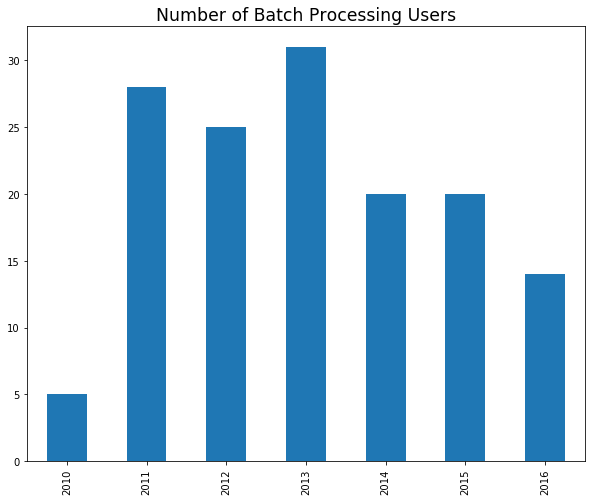

In [281]:
df_UnqUsr = df[["QDate", "Owner"]]
df_UnqUsr = df_UnqUsr.assign(timestamp = df_UnqUsr.QDate.astype('datetime64[ms]'))
df_UnqUsr = df_UnqUsr.set_index("timestamp")
grped_UnqUsr = df_UnqUsr.groupby(df_UnqUsr.index.year).agg({"Owner":lambda x: x.nunique()})
#print(grped_UnqUsr)
fig = plt.figure(figsize=(10,8))
ax = grped_UnqUsr["Owner"].plot(kind = "bar")
ax.set_title("Number of Batch Processing Users", size = "xx-large")
#ax.set_xlabel("Year", size = "large")
fig.savefig("BatchUnqUsrPerYr.png")
plt.show()

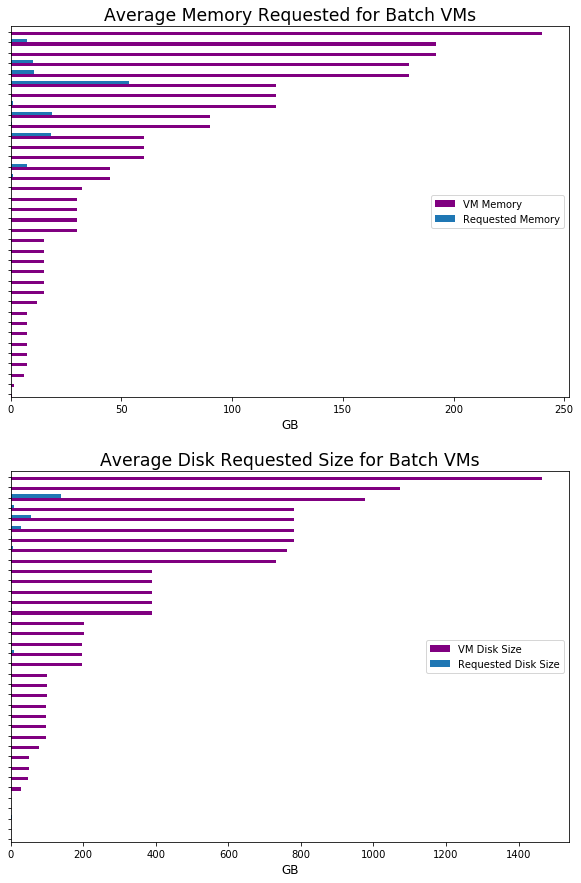

In [282]:
df_VMInfo = df[["VMSpec.DISK", "VMSpec.RAM", "RequestDisk", "RequestMemory", "VMInstanceType"]]\
            .dropna(how = "all", subset = ["VMInstanceType"])#.set_index("VMInstanceType")
df_VMInfo = df_VMInfo[(df_VMInfo.VMInstanceType != "c4.med") &\
                        (df_VMInfo.VMInstanceType != "12345678-6341-470e-92b7-5142014e7c5e") &\
                        (df_VMInfo.VMInstanceType != "5c1ed3eb-6341-470e-92b7-5142014e7c5e")]

VMAlias = {
    "c16.med":"13efd2a1-2fd8-48c4-822f-ce9bdc0e0004",
    "c2.med":"23090fc1-bdf7-433e-9804-a7ec3d11de08",
    "p8-12gb":"2cb70964-721d-47ff-badb-b702898b6fc2",
    "c4.hi":"5112ed51-d263-4cc7-8b0f-7ef4782f783c",
    "c2.low":"6c1ed3eb-6341-470e-92b7-5142014e7c5e",
    "c8.med":"72009191-d893-4a07-871c-7f6e50b4e110",
    "c4.low":"8061864c-722b-4f79-83af-91c3a835bd48",
    "p8-6gb":"848b71a2-ae6b-4fcf-bba4-b7b0fccff5cf",
    "c8.low":"8953676d-def7-4290-b239-4a14311fbb69",
    "c8.hi":"a55036b9-f40c-4781-a293-789647c063d7",
    "c16.hi":"d816ae8b-ab7d-403d-ae5f-f457b775903d",
    "p1-0.75gb-tobedeleted":"f9f6fbd7-a0af-4604-8911-041ea6cbbbe4"
}
df_VMInfo["VMSpec.DISK"] = (df_VMInfo["VMSpec.DISK"] * 1000)
df_VMInfo = df_VMInfo.replace({"VMInstanceType":VMAlias})
df_VMInfo = df_VMInfo.set_index("VMInstanceType")
grped_VMInfo = df_VMInfo.groupby(df_VMInfo.index).mean().sort_values(by = "VMSpec.RAM")#.apply(np.sqrt)
#print(grped_VMInfo.head(40))
#print(len(grped_VMInfo))
## plot
fig = plt.figure(figsize=(10,15))
fig.add_subplot(211)
ax = (grped_VMInfo["VMSpec.RAM"]/1024).plot(kind = "barh", color = "purple", width = 0.3, position = 1)
(grped_VMInfo["RequestMemory"]/1024).plot(kind = "barh", width = 0.3, position = 0, ax = ax)
# ax_yticks = [1, 2, 4 ,6 ,8 ,10]
# ax.set_yticks([x for x in np.sqrt([y * 1000000 for y in ax_yticks])])
# ax.set_yticklabels([str(x) for x in ax_yticks])
ax.set_title("Average Memory Requested for Batch VMs", size = "xx-large")
ax.set_xlabel("GB", size = "large")
ax.set_ylabel("", size = "large")
ax.set_yticklabels([])
#ax.set_xticklabels(ax.xaxis.get_ticklabels(), rotation=90)
ax.legend(["VM Memory", "Requested Memory"], loc = 7)
## 2nd plt
fig.add_subplot(212)
grped_VMInfo = grped_VMInfo.sort_values(by = "VMSpec.DISK")
ax2 = (grped_VMInfo["VMSpec.DISK"]/1024).plot(kind = "barh", color = "purple", width = 0.3, position = 1)
(grped_VMInfo["RequestDisk"]/1024).plot(kind = "barh", width = 0.3, position = 0, ax = ax2)
ax2.set_title("Average Disk Requested Size for Batch VMs", size = "xx-large")
ax2.set_xlabel("GB", size = "large")
ax2.set_ylabel("", size = "large")
ax2.legend(["VM Disk Size", "Requested Disk Size"], loc = 7)
ax2.set_yticklabels([])
#ax2.set_xticklabels(ax2.xaxis.get_ticklabels(), rotation=90)
fig.savefig("BatchAvgReqMemReqDsk.png")
plt.show()

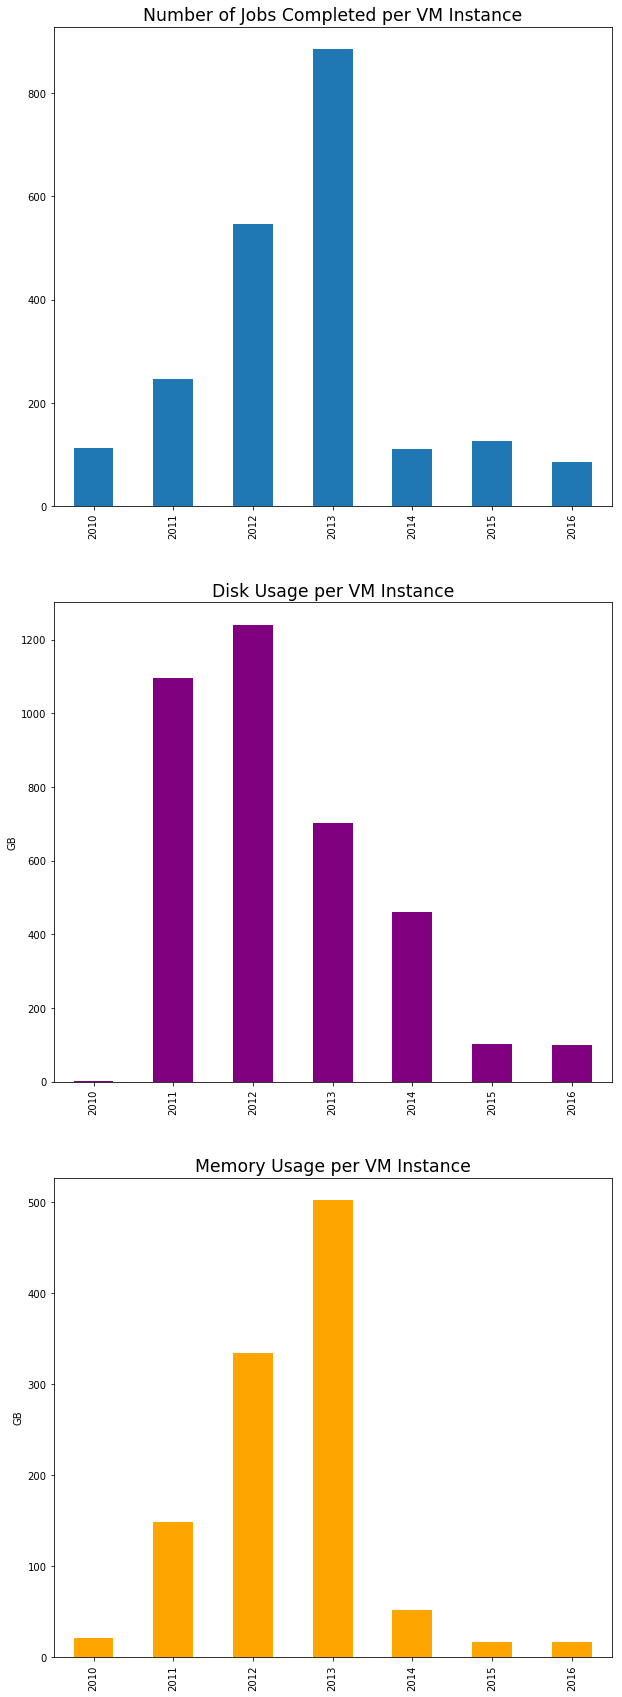

In [297]:
df_VMInfo2 = df[["DiskUsage", "MemoryUsage", "QDate", "VMInstanceName", "JobStatus"]]\
            .dropna(how = "all", subset = ["VMInstanceName"])
# successful jobs only    
df_VMInfo2 = df_VMInfo2[df_VMInfo2.JobStatus == 4]     
df_VMInfo2["timestamp"] = df_VMInfo2.QDate.astype('datetime64[ms]')
df_VMInfo2 = df_VMInfo2.set_index("timestamp")
grped_VMInfo2 = df_VMInfo2.groupby(df_VMInfo2.index.year)\
                        .agg({"QDate":"count", "VMInstanceName":lambda x: x.nunique(),\
                               "DiskUsage":"sum", "MemoryUsage":"sum"})
grped_VMInfo2 = grped_VMInfo2.assign(JobPerVM = (grped_VMInfo2.QDate / grped_VMInfo2.VMInstanceName))
grped_VMInfo2 = grped_VMInfo2.assign(DskPerVM = (grped_VMInfo2.DiskUsage / grped_VMInfo2.VMInstanceName))
grped_VMInfo2 = grped_VMInfo2.assign(RamPerVM = (grped_VMInfo2.MemoryUsage / grped_VMInfo2.VMInstanceName))

#print(grped_VMInfo2)

fig = plt.figure(figsize=(10,30))
fig.add_subplot(311)
ax = grped_VMInfo2.JobPerVM.plot(kind = "bar")
ax.set_title("Number of Jobs Completed per VM Instance", size = "xx-large")
#ax.set_xlabel("Year", size = "large")
ax.set_ylabel("")
fig.add_subplot(312)
ax2 = (grped_VMInfo2.DskPerVM/1024).plot(kind = "bar", color = "purple")
ax2.set_title("Disk Usage per VM Instance", size = "xx-large")
#ax2.set_xlabel("Year", size = "large")
ax2.set_ylabel("GB")
fig.add_subplot(313)
ax3 = (grped_VMInfo2.RamPerVM/1024).plot(kind = "bar", color = "orange")
ax3.set_title("Memory Usage per VM Instance", size = "xx-large")
#ax3.set_xlabel("Year", size = "large")
ax3.set_ylabel("GB")
fig.savefig("BatchNumJobDskMemUsgPerVMIns.png")
plt.show()

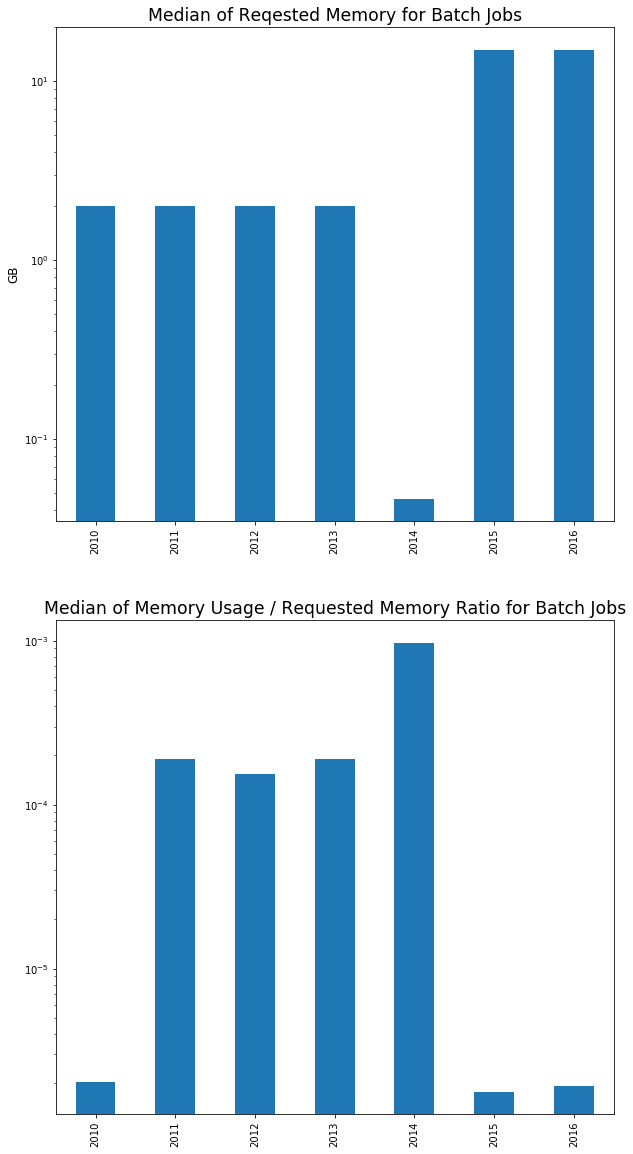

In [298]:
# for postOS RequestMemory = VMSpec.RAM
df_VMInfo3 = df[["RequestMemory", "MemoryUsage", "QDate", "JobStatus", "VMSpec.RAM"]]
# completed jobs only
df_VMInfo3 = df_VMInfo3[df_VMInfo3.JobStatus == 4]
df_VMInfo3 = df_VMInfo3.assign(timestamp = df_VMInfo3.QDate.astype("datetime64[ms]"))
df_VMInfo3 = df_VMInfo3.assign(RamRatio = (df_VMInfo3.MemoryUsage / df_VMInfo3.RequestMemory))
df_VMInfo3 = df_VMInfo3.assign(RamRatioPostOS = (df_VMInfo3.MemoryUsage / df_VMInfo3["VMSpec.RAM"]))
#df_VMInfo3 = df_VMInfo3.assign(DskRatio = (df_VMInfo3.DiskUsage / df_VMInfo3.RequestDisk))
# fig = plt.figure(figsize=(14,49))
# # 2010
# fig.add_subplot(721)
# ax = df_VMInfo3[df_VMInfo3.timestamp < "2011-01-01"]["RequestMemory"].plot(kind = "hist", bins = 200)
# ax.set_title("Hist. of Requested Memory, 2010")
# ax.set_xlabel("Megabytes")
# fig.add_subplot(722)
# ax2 = df_VMInfo3[df_VMInfo3.timestamp < "2011-01-01"]["RamRatio"].plot(kind = "hist", bins = 200, range = (0, 1))
# ax2.set_title("Hist. of ReqMem / MemUsg, 2010")
# # 2011
# fig.add_subplot(723)
# ax3 = df_VMInfo3[(df_VMInfo3.timestamp < "2012-01-01") & (df_VMInfo3.timestamp >= "2011-01-01")]["RequestMemory"]\
#         .plot(kind = "hist", bins = 200)
# ax3.set_title("Hist. of Requested Memory, 2011")
# ax3.set_xlabel("Megabytes")
# fig.add_subplot(724)
# ax4 = df_VMInfo3[(df_VMInfo3.timestamp < "2012-01-01") & (df_VMInfo3.timestamp >= "2011-01-01")]["RamRatio"]\
#         .plot(kind = "hist", bins = 200, range = (0, 1))
# ax4.set_title("Hist. of ReqMem / MemUsg, 2011")
# # 2012
# fig.add_subplot(725)
# ax5 = df_VMInfo3[(df_VMInfo3.timestamp < "2013-01-01") & (df_VMInfo3.timestamp >= "2012-01-01")]["RequestMemory"]\
#         .plot(kind = "hist", bins = 200)
# ax5.set_title("Hist. of Requested Memory, 2012")
# ax5.set_xlabel("Megabytes")
# fig.add_subplot(726)
# ax6 = df_VMInfo3[(df_VMInfo3.timestamp < "2013-01-01") & (df_VMInfo3.timestamp >= "2012-01-01")]["RamRatio"]\
#         .plot(kind = "hist", bins = 200, range = (0, 1))
# ax6.set_title("Hist. of ReqMem / MemUsg, 2012")
# # 2013
# fig.add_subplot(727)
# ax7 = df_VMInfo3[(df_VMInfo3.timestamp < "2014-01-01") & (df_VMInfo3.timestamp >= "2013-01-01")]["RequestMemory"]\
#         .plot(kind = "hist", bins = 200)
# ax7.set_title("Hist. of Requested Memory, 2013")
# ax7.set_xlabel("Megabytes")
# fig.add_subplot(728)
# ax8 = df_VMInfo3[(df_VMInfo3.timestamp < "2014-01-01") & (df_VMInfo3.timestamp >= "2013-01-01")]["RamRatio"]\
#         .plot(kind = "hist", bins = 200, range = (0, 1))
# ax8.set_title("Hist. of ReqMem / MemUsg, 2013")
# # 2014
# fig.add_subplot(729)
# ax9 = df_VMInfo3[(df_VMInfo3.timestamp < "2015-01-01") & (df_VMInfo3.timestamp >= "2014-01-01")]["RequestMemory"]\
#         .plot(kind = "hist", bins = 200)
# ax9.set_title("Hist. of Requested Memory, 2014")
# ax9.set_xlabel("Megabytes")
# fig.add_subplot(7,2,10)
# ax10 = df_VMInfo3[(df_VMInfo3.timestamp < "2015-01-01") & (df_VMInfo3.timestamp >= "2014-01-01")]["RamRatio"]\
#         .plot(kind = "hist", bins = 200, range = (0, 1))
# ax10.set_title("Hist. of ReqMem / MemUsg, 2014")
# # 2015
# fig.add_subplot(7,2,11)
# ax11 = df_VMInfo3[(df_VMInfo3.timestamp < "2016-01-01") & (df_VMInfo3.timestamp >= "2015-01-01")]["VMSpec.RAM"]\
#         .plot(kind = "hist", bins = 200)
# ax11.set_title("Hist. of Requested Memory, 2015")
# ax11.set_xlabel("Megabytes")
# fig.add_subplot(7,2,12)
# ax12 = df_VMInfo3[(df_VMInfo3.timestamp < "2016-01-01") & (df_VMInfo3.timestamp >= "2015-01-01")]["RamRatioPostOS"]\
#         .plot(kind = "hist", bins = 200, range = (0, 1))
# ax12.set_title("Hist. of ReqMem / MemUsg, 2015")
# # 2016
# fig.add_subplot(7,2,13)
# ax13 = df_VMInfo3[(df_VMInfo3.timestamp < "2017-01-01") & (df_VMInfo3.timestamp >= "2016-01-01")]["VMSpec.RAM"]\
#         .plot(kind = "hist", bins = 200)
# ax13.set_title("Hist. of Requested Memory, 2016")
# ax13.set_xlabel("Megabytes")
# fig.add_subplot(7,2,14)
# ax14 = df_VMInfo3[(df_VMInfo3.timestamp < "2017-01-01") & (df_VMInfo3.timestamp >= "2016-01-01")]["RamRatioPostOS"]\
#         .plot(kind = "hist", bins = 200, range = (0, 1))
# ax14.set_title("Hist. of ReqMem / MemUsg, 2016") 

fig = plt.figure(figsize = (20, 10))

reqMem = [df_VMInfo3[df_VMInfo3.timestamp < "2011-01-01"]["RequestMemory"].median(),\
          df_VMInfo3[(df_VMInfo3.timestamp < "2012-01-01") & (df_VMInfo3.timestamp >= "2011-01-01")]["RequestMemory"].median(),\
          df_VMInfo3[(df_VMInfo3.timestamp < "2013-01-01") & (df_VMInfo3.timestamp >= "2012-01-01")]["RequestMemory"].median(),\
          df_VMInfo3[(df_VMInfo3.timestamp < "2014-01-01") & (df_VMInfo3.timestamp >= "2013-01-01")]["RequestMemory"].median(),\
          df_VMInfo3[(df_VMInfo3.timestamp < "2015-01-01") & (df_VMInfo3.timestamp >= "2014-01-01")]["RequestMemory"].median(),\
          df_VMInfo3[(df_VMInfo3.timestamp < "2016-01-01") & (df_VMInfo3.timestamp >= "2015-01-01")]["VMSpec.RAM"].median(),\
          df_VMInfo3[(df_VMInfo3.timestamp < "2017-01-01") & (df_VMInfo3.timestamp >= "2016-01-01")]["VMSpec.RAM"].median()]

ratio = [df_VMInfo3[df_VMInfo3.timestamp < "2011-01-01"]["RamRatio"].median(),\
          df_VMInfo3[(df_VMInfo3.timestamp < "2012-01-01") & (df_VMInfo3.timestamp >= "2011-01-01")]["RamRatio"].median(),\
          df_VMInfo3[(df_VMInfo3.timestamp < "2013-01-01") & (df_VMInfo3.timestamp >= "2012-01-01")]["RamRatio"].median(),\
          df_VMInfo3[(df_VMInfo3.timestamp < "2014-01-01") & (df_VMInfo3.timestamp >= "2013-01-01")]["RamRatio"].median(),\
          df_VMInfo3[(df_VMInfo3.timestamp < "2015-01-01") & (df_VMInfo3.timestamp >= "2014-01-01")]["RamRatio"].median(),\
          df_VMInfo3[(df_VMInfo3.timestamp < "2016-01-01") & (df_VMInfo3.timestamp >= "2015-01-01")]["RamRatioPostOS"].median(),\
          df_VMInfo3[(df_VMInfo3.timestamp < "2017-01-01") & (df_VMInfo3.timestamp >= "2016-01-01")]["RamRatioPostOS"].median()]

#print(reqMem, ratio)
t = [x for x in range (2010, 2017)]
s_ReqMem = pd.Series(reqMem, index = t)
s_Ratio = pd.Series(ratio, index = t)
fig = plt.figure(figsize = (10, 20))
ax = fig.add_subplot(211)
ax.set_title("Median of Reqested Memory for Batch Jobs", size = "xx-large")
ax.set_ylabel("GB", size = "large")
(s_ReqMem/1024).plot(kind = "bar", ax = ax, logy = True)
ax2 = fig.add_subplot(212)
ax2.set_title("Median of Memory Usage / Requested Memory Ratio for Batch Jobs", size = "xx-large")
(s_Ratio/1024).plot(kind = "bar", ax = ax2, logy = True)
fig.savefig("BatchMedReqMem.png")
plt.show()

/home/superliuxz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/superliuxz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


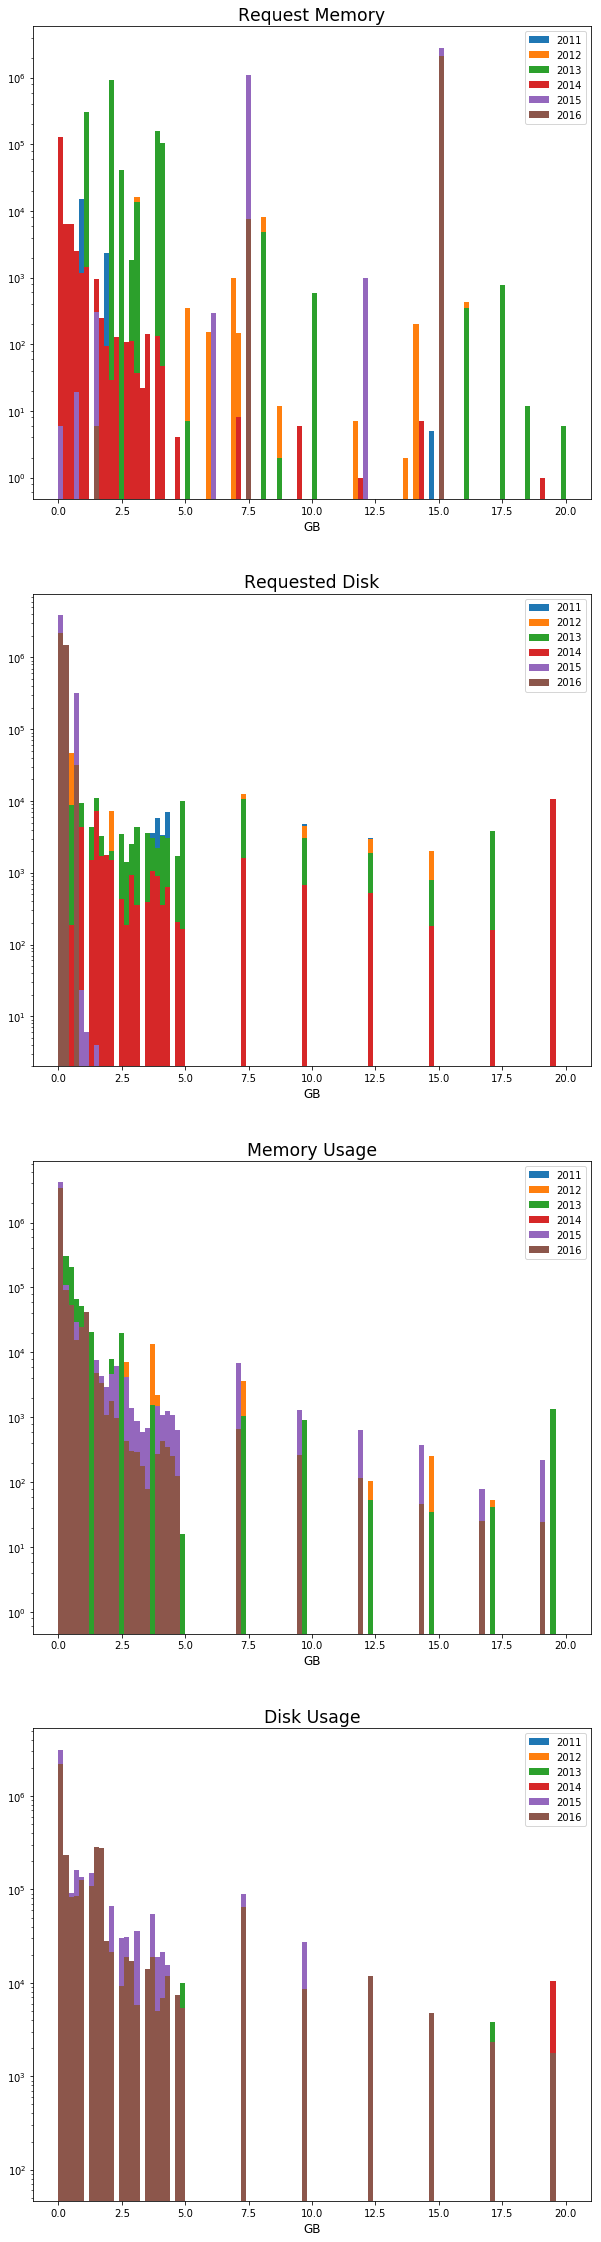

In [285]:
# df_VMInfo4 = df[["DiskUsage", "MemoryUsage", "JobStatus", "QDate"]]
# df_VMInfo4 = df_VMInfo4.assign(timestamp = df_VMInfo4.QDate.astype("datetime64[ms]"))
# df_VMInfo4 = df_VMInfo4.assign(Year = pd.DatetimeIndex(df_VMInfo4['timestamp']).year)
# df_VMInfo4 = df_VMInfo4.assign(DiskUsage = df_VMInfo4.DiskUsage / 1024)
# df_VMInfo4 = df_VMInfo4.assign(MemoryUsage = df_VMInfo4.MemoryUsage / 1024)
# df_VMInfo4 = df_VMInfo4[(df_VMInfo4.JobStatus == 4) & (df_VMInfo4.DiskUsage > 0) & (df_VMInfo4.MemoryUsage > 0)] # completed
# fig = plt.figure(figsize = (10,20))
# ax = fig.add_subplot(211)
# ax.set_title("Disk Usage", size = "xx-large")
# ax.set_ylabel("GB", size = "large")
# ax.set_yscale("log")
# df_VMInfo4.boxplot(column = "DiskUsage", by = "Year", rot = 90, ax = ax)
# ax2 = fig.add_subplot(212)
# ax2.set_title("Memory Usage", size = "xx-large")
# ax2.set_ylabel("GB", size = "large")
# ax2.set_yscale("log")
# df_VMInfo4.boxplot(column = "MemoryUsage", by = "Year", rot = 90, ax = ax2)
# plt.show()
df_VMInfo4 = df[["RequestDisk", "RequestMemory", "VMSpec.RAM", "VMSpec.DISK", "JobStatus", "QDate", "MemoryUsage", "DiskUsage"]]
df_VMInfo4 = df_VMInfo4.assign(RequestDisk = (df_VMInfo4.RequestDisk / 1024))
df_VMInfo4 = df_VMInfo4.assign(RequestMemory = (df_VMInfo4.RequestMemory / 1024))
df_VMInfo4 = df_VMInfo4.assign(DiskUsage = (df_VMInfo4.DiskUsage / 1024))
df_VMInfo4 = df_VMInfo4.assign(MemoryUsage = (df_VMInfo4.MemoryUsage / 1024))
df_VMInfo4 = df_VMInfo4.assign(VMSpecRAM = (df_VMInfo4["VMSpec.RAM"] / 1024))
df_VMInfo4 = df_VMInfo4.assign(VMSpecDISK = (df_VMInfo4["VMSpec.DISK"] / 1024))

df_VMInfo4 = df_VMInfo4.assign(timestamp = df_VMInfo4.QDate.astype("datetime64[ms]"))
df_VMInfo4 = df_VMInfo4.assign(Year = pd.DatetimeIndex(df_VMInfo4['timestamp']).year)
#print(df_VMInfo4[df_VMInfo4.Year == 2016]["VMSpec.RAM"].max())
fig = plt.figure(figsize = (10, 40))
ax = fig.add_subplot(411)
ax.hist(df_VMInfo4[df_VMInfo4.Year == 2011]["RequestMemory"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax.hist(df_VMInfo4[df_VMInfo4.Year == 2012]["RequestMemory"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax.hist(df_VMInfo4[df_VMInfo4.Year == 2013]["RequestMemory"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax.hist(df_VMInfo4[df_VMInfo4.Year == 2014]["RequestMemory"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax.hist(df_VMInfo4[df_VMInfo4.Year == 2015]["VMSpecRAM"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax.hist(df_VMInfo4[df_VMInfo4.Year == 2016]["VMSpecRAM"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax.legend(["2011", "2012", "2013", "2014", "2015", "2016"], loc = 1)
ax.set_title("Request Memory", size = "xx-large")
ax.set_xlabel("GB", size = "large")

ax2 = fig.add_subplot(412)
ax2.hist(df_VMInfo4[df_VMInfo4.Year == 2011]["RequestDisk"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax2.hist(df_VMInfo4[df_VMInfo4.Year == 2012]["RequestDisk"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax2.hist(df_VMInfo4[df_VMInfo4.Year == 2013]["RequestDisk"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax2.hist(df_VMInfo4[df_VMInfo4.Year == 2014]["RequestDisk"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax2.hist(df_VMInfo4[df_VMInfo4.Year == 2015]["VMSpecDISK"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax2.hist(df_VMInfo4[df_VMInfo4.Year == 2016]["VMSpecDISK"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax2.legend(["2011", "2012", "2013", "2014", "2015", "2016"], loc = 1)
ax2.set_title("Requested Disk", size = "xx-large")
ax2.set_xlabel("GB", size = "large")

ax3 = fig.add_subplot(413)
ax3.hist(df_VMInfo4[df_VMInfo4.Year == 2011]["MemoryUsage"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax3.hist(df_VMInfo4[df_VMInfo4.Year == 2012]["MemoryUsage"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax3.hist(df_VMInfo4[df_VMInfo4.Year == 2013]["MemoryUsage"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax3.hist(df_VMInfo4[df_VMInfo4.Year == 2014]["MemoryUsage"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax3.hist(df_VMInfo4[df_VMInfo4.Year == 2015]["MemoryUsage"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax3.hist(df_VMInfo4[df_VMInfo4.Year == 2016]["MemoryUsage"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax3.legend(["2011", "2012", "2013", "2014", "2015", "2016"], loc = 1)
ax3.set_title("Memory Usage", size = "xx-large")
ax3.set_xlabel("GB", size = "large")

ax4 = fig.add_subplot(414)
ax4.hist(df_VMInfo4[df_VMInfo4.Year == 2011]["DiskUsage"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax4.hist(df_VMInfo4[df_VMInfo4.Year == 2012]["DiskUsage"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax4.hist(df_VMInfo4[df_VMInfo4.Year == 2013]["DiskUsage"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax4.hist(df_VMInfo4[df_VMInfo4.Year == 2014]["DiskUsage"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax4.hist(df_VMInfo4[df_VMInfo4.Year == 2015]["DiskUsage"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax4.hist(df_VMInfo4[df_VMInfo4.Year == 2016]["DiskUsage"], bins = 100, histtype = "bar", range = (0, 20), log = True)
ax4.legend(["2011", "2012", "2013", "2014", "2015", "2016"], loc = 1)
ax4.set_title("Disk Usage", size = "xx-large")
ax4.set_xlabel("GB", size = "large")
fig.savefig("BatchHistReqMemDskUsgMemDsk.png")
plt.show()

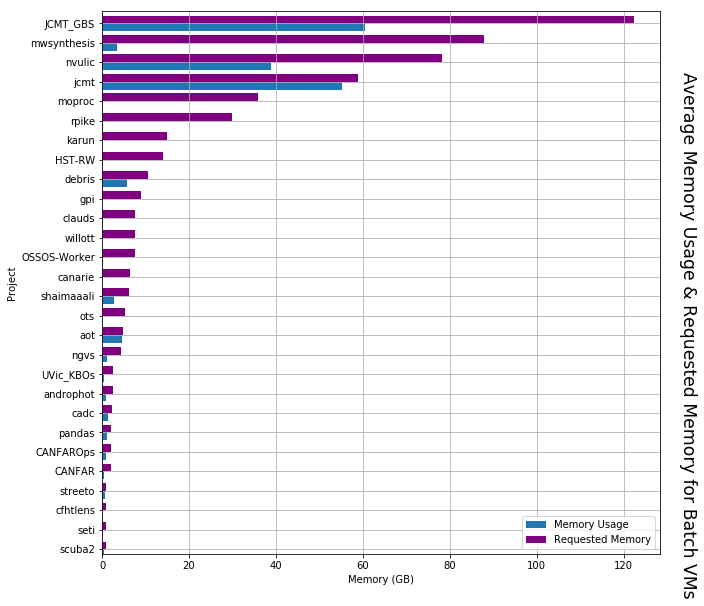

In [299]:
df_VMInfo5 = df[["QDate", "MemoryUsage", "JobStatus", "Project", "RequestMemory", "VMSpec.DISK", "VMSpec.RAM"]]
df_VMInfo5 = df_VMInfo5.assign(timestamp = df_VMInfo5.QDate.astype("datetime64[ms]"))
df_VMInfo5 = df_VMInfo5.assign(Year = pd.DatetimeIndex(df_VMInfo4['timestamp']).year)
df_VMInfo5.loc[df_VMInfo5['Year'] >= 2015, "RequestMemory"] = df_VMInfo5.loc[df_VMInfo5['Year'] >= 2015, "VMSpec.RAM"]
# df_VMInfo5[df_VMInfo5.Year >= 2015]["RequestMemory"] = df_VMInfo5["VMSpec.RAM"]
# df_VMInfo5[df_VMInfo5.Year >= 2015]["RequestDisk"] = df_VMInfo5["VMSpec.DISK"]
df_VMInfo5 = df_VMInfo5[df_VMInfo5.JobStatus == 4].set_index("Project")
# grped_VMInfo5 = df_VMInfo5.groupby(df_VMInfo5.index).mean().sort_values(by = "RequestDisk")
# fig = plt.figure(figsize = (10,20))
# ax = fig.add_subplot(211)
# (grped_VMInfo5["DiskUsage"] / 1024).plot(kind = "barh", width = 0.4, position = 1, grid = True)
# #ax.set_title("Average Disk & Memory Usage", size = "xx-large")
# ax.set_title("Average Disk Usage & Request Disk", size = "xx-large", x = 1.05, y = 0.85, rotation = -90)
# ax.set_xlabel("Disk Usage (GB)")
# ax.legend(["DiskUsage"], loc = 1, bbox_to_anchor = (1, 0.95))
# ax2 = ax.twiny()
# (grped_VMInfo5["RequestDisk"] / 1024).plot(kind = "barh", width = 0.4, position = 0, color = "purple")
# ax2.set_xlabel("Request Disk (GB)")
# ax2.legend(["RequestDisk"], loc = 4)
fig = plt.figure(figsize = (10,10))
grped_VMInfo5 = df_VMInfo5.groupby(df_VMInfo5.index).mean().sort_values(by = "RequestMemory")
ax3 = fig.add_subplot(111)
(grped_VMInfo5["MemoryUsage"] / 1024).plot(kind = "barh", ax = ax3, width = 0.4, position = 1, grid = True)
ax3.set_title("Average Memory Usage & Requested Memory for Batch VMs", size = "xx-large", x = 1.05, y = 0.85, rotation = -90)
ax3.set_xlabel("Memory (GB)")
#ax3.legend(["MemoryUsage"], loc = 1, bbox_to_anchor = (1, 0.95))
#ax4 = ax3.twiny()
(grped_VMInfo5["RequestMemory"] / 1024).plot(kind = "barh", ax = ax3, width = 0.4, position = 0, grid = True, color = "purple")
#ax4.set_xlabel("Request Memory (GB)")
ax3.legend(["Memory Usage","Requested Memory"], loc = 4)
fig.savefig("BatchAvgMemUsgReqMemPerProj.png")
plt.show()

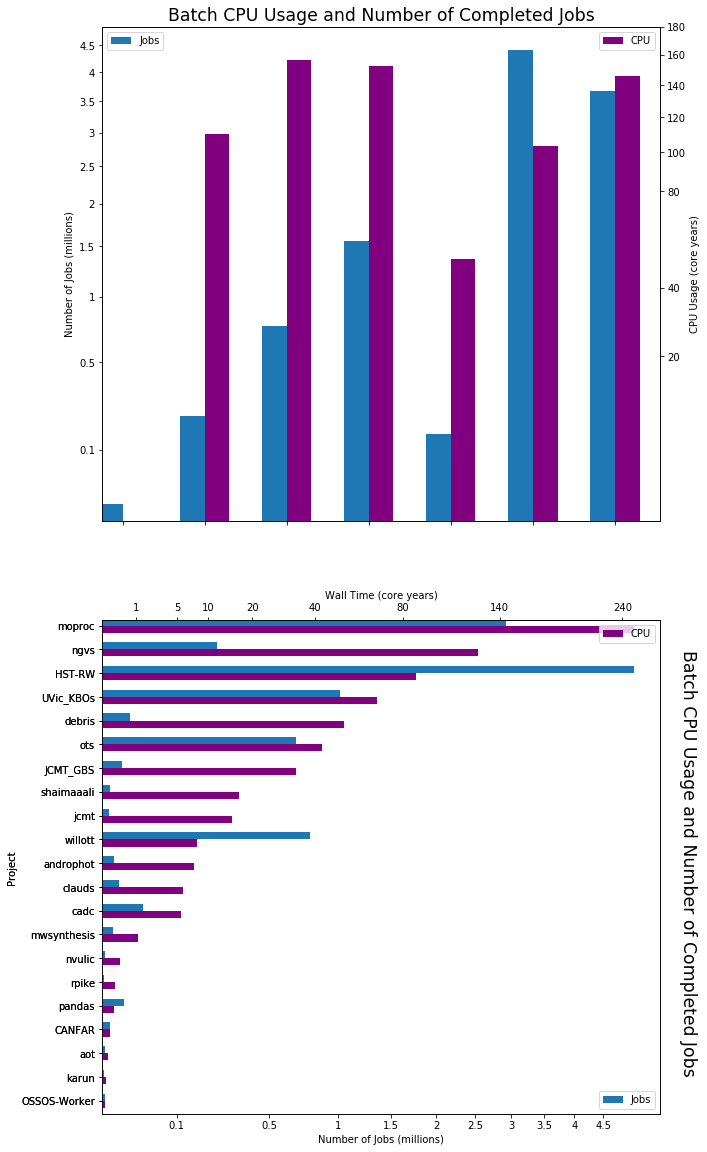

In [301]:
df_Overview = df[["QDate", "CumulativeSlotTime", "Project", "Owner"]]
#df_Overview["timestamp"] = df_Overview.QDate.astype('datetime64[ms]')
df_Overview = df_Overview.assign(timestamp = df_Overview.QDate.astype('datetime64[ms]'))
#print("where is the warning msg")
df_Overview = df_Overview.set_index("timestamp")
grped_Overview = df_Overview.groupby(df_Overview.index.year).agg({"QDate":"count", "CumulativeSlotTime":"sum"})\
                .apply(np.sqrt)
#print(grped_Overview)
# plot
fig = plt.figure(figsize=(10,20))
fig.add_subplot(211)
ax = grped_Overview["QDate"].plot(kind = "bar", legend = False, width = 0.3, position = 1)
ax2 = ax.twinx() 
grped_Overview["CumulativeSlotTime"].plot(kind = "bar", color = "purple", position = 0, legend = False, width = 0.3, ax = ax2)
ax_yticks = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5] # #jobs in million
ax.set_yticks([x for x in np.sqrt([y * 1000000 for y in ax_yticks])])
ax.set_yticklabels([str(x) for x in ax_yticks])
ax.set_title("Batch CPU Usage and Number of Completed Jobs", size = "xx-large")
#ax.set_xlabel("Year")
ax.set_ylabel("Number of Jobs (millions)")
ax.legend(["Jobs"], loc = 2)
ax2_yticks = [20, 40, 80, 100, 120, 140, 160, 180] # coreyears
ax2.set_yticks([x for x in np.sqrt(np.dot(ax2_yticks, 365*24*3600))])
ax2.set_yticklabels([str(x) for x in ax2_yticks])
ax2.set_ylabel("CPU Usage (core years)")
ax2.legend(["CPU"], loc = 1)
#2nd plot
fig.add_subplot(212)
df_Overview = df_Overview.reset_index().set_index("Project")
grped_Overview = df_Overview.groupby(df_Overview.index).agg({"QDate":"count", "CumulativeSlotTime":"sum"})\
                .apply(np.sqrt).dropna(how = "any", subset = ["CumulativeSlotTime"])\
                .sort_values(by = "CumulativeSlotTime")
grped_Overview = grped_Overview[grped_Overview.CumulativeSlotTime > 40]        
#print(grped_Overview)    
ax3 = grped_Overview["QDate"].plot(kind = "barh", legend = False, width = 0.3, position = 0)
ax4 = ax3.twiny()
grped_Overview["CumulativeSlotTime"]\
    .plot(kind = "barh", color = "purple", legend = False, width = 0.3, position = 1, ax = ax4)
ax3.set_title("Batch CPU Usage and Number of Completed Jobs", size = "xx-large", x = 1.05, y = 0.9, rotation = -90)
ax3.set_xticks([x for x in np.sqrt([y * 1000000 for y in ax_yticks])])
ax3.set_xticklabels([str(x) for x in ax_yticks])
ax3.set_xlabel("Number of Jobs (millions)")
ax3.legend(["Jobs"], loc = 4)
ax4_xticks = [1, 5, 10, 20, 40, 80, 140, 240] # coreyears
ax4.set_xticks([x for x in np.sqrt(np.dot(ax4_xticks, 365*24*3600))])
ax4.set_xticklabels([str(x) for x in ax4_xticks])
ax4.set_xlabel("Wall Time (core years)")
ax4.legend(["CPU"], loc = 1)
# 3rd plot
#fig.add_subplot(313)
#df_Overview = df_Overview.reset_index().set_index("Owner")
#grped_Overview = df_Overview.groupby(df_Overview.index).agg({"QDate":"count", "CumulativeSlotTime":"sum"})\
#                .apply(np.sqrt).dropna(how = "any", subset = ["CumulativeSlotTime"])\
#                .sort_values(by = "CumulativeSlotTime")
#grped_Overview = grped_Overview[grped_Overview.CumulativeSlotTime > 166]           
#print(grped_Overview)          
#ax5 = grped_Overview["QDate"].plot(kind = "barh", legend = False, width = 0.3, position = 0)
#ax6 = ax5.twiny()
#grped_Overview["CumulativeSlotTime"]\
#    .plot(kind = "barh", color = "purple", legend = False, width = 0.3, position = 1, ax = ax6)
#ax5.set_title("CPU Usage Number of Completed Jobs", size = "xx-large", x = 1.05, y = 0.9, rotation = -90)
#ax5.set_xticks([x for x in np.sqrt([y * 1000000 for y in ax_yticks])])
#ax5.set_xticklabels([str(x) for x in ax_yticks])
#ax5.set_xlabel("Number of Jobs (millions)")
#ax5.legend(["Jobs"], loc = 4)
#ax6_xticks = [1, 5, 10, 20, 40, 80, 140, 240] # coreyears
#ax6.set_xticks([x for x in np.sqrt(np.dot(ax4_xticks, 365*24*3600))])
#ax6.set_xticklabels([str(x) for x in ax4_xticks])
#ax6.set_xlabel("CPU Usage (core years)")
#ax6.legend(["CPU"], loc = 1)
fig.savefig("BatchSummary.png")
plt.show()

In [ ]:
# OPENSTACK BELOW

In [15]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path
import mpld3
import re

csv_path = "/data/openstack"

DType = {
"day":np.str_,
"cpuhours":np.str_,
"diskgbhours":np.str_,
"rammbhours":np.str_,
"nserver":np.str_
}

df_OS = pd.DataFrame()

for dirpath, dirnames, filenames in os.walk(csv_path):
    for filename in [f for f in filenames if f.endswith(".csv")]:
        f = os.path.join(dirpath, filename)
        r = re.search("\/([^\/]+)\/openstack_usage_(.+).csv", f)
        loc = r.group(1)
        proj = r.group(2)
        #print(loc, proj)
        tmp = pd.read_csv(f, dtype = DType, parse_dates = ["day"])
        tmp = tmp.assign(Loc = loc)
        tmp = tmp.assign(Proj = proj.replace("canfar-", ""))
        #print(tmp.head(5))
        df_OS = df_OS.append(tmp)
del tmp

df_OS = df_OS.assign(Cpuhours = df_OS.cpuhours.str.replace("None", "0").astype(np.float64))
df_OS = df_OS.assign(Diskgbhours = df_OS.diskgbhours.str.replace("None", "0").astype(np.float64))
df_OS = df_OS.assign(Rammbhours = df_OS.rammbhours.str.replace("None", "0").astype(np.float64))
df_OS = df_OS.assign(Nserver = df_OS.nserver.str.replace("None", "0").astype(np.float64))
#print(df_OS)

In [16]:
import json

with open("/data/canfar_projects.json", "r") as f:
    data = json.load(f)
    
projCateg = {}    
for i in range(len(data)):
    if data[i]["tenants"][0] != "":
        for j in range(len(data[i]["tenants"])):
            #print(data[i]["tenants"][j] + ",", data[i]["categories"][0])
            projCateg[data[i]["tenants"][j].replace("-", "_")] = data[i]["categories"][0]

print(projCateg)
for k in projCateg.keys():
    df_OS.loc[df_OS.Proj == k, "Categ"] = projCateg[k] 
    df.loc[df.Project == k, "Categ"] = projCateg[k] 

{'androphot': 'Galaxies', 'astroai': 'Solar and Stellar', 'ATP_Mechanics': 'Instrumentation and Methods', 'ATP_Software': 'Instrumentation and Methods', 'aot': 'Instrumentation and Methods', 'cadc': 'CANFAR', 'moproc': 'CANFAR', 'HST_RW': 'CANFAR', 'ots': 'Cosmology', 'willott': 'CANFAR', 'CANFAR': 'CANFAR', 'CANFAROps': 'CANFAR', 'CANFAR_east': 'CANFAR', 'CANFAROps_east': 'CANFAR', 'canarie': 'CANFAR', 'cesharon': 'Galaxies', 'cfht': 'CANFAR', 'clauds': 'Galaxies', 'cyberska': 'CANFAR', 'dao': 'CANFAR', 'debris': 'Solar and Stellar', 'dragonfly': 'Galaxies', 'EAO': 'CANFAR', 'jsa': 'CANFAR', 'gpi': 'Earth and Planetary', 'JCMT_GBS': 'Solar and Stellar', 'karun': 'Galaxies', 'mwsynthesis': 'Solar and Stellar', 'ngvs': 'Galaxies', 'nugrid_admin': 'Solar and Stellar', 'nvulic': 'Galaxies', 'OSSOS_Worker': 'Earth and Planetary', 'pandas': 'Galaxies', 'pscicluna': 'Solar and Stellar', 'rpike': 'Earth and Planetary', 'UVic_KBOs': 'Earth and Planetary', 'scuba2': 'Solar and Stellar', 'seti':

In [31]:
tmp = df_OS[(df_OS.day >= "2016-01-01") & (df_OS.day < "2017-01-01")]
tmp.set_index("Proj", inplace = True)
tmp.groupby(tmp.index).sum().sort_values("Nserver").to_csv("/home/superliuxz/2016.csv")

# tmp = df_OS[(df_OS.day >= "2016-01-01") & (df_OS.day < "2017-01-01")]
# tmp.set_index("Proj", inplace = True)
# tmp.groupby(tmp.index).sum().sort_values("Nserver")

2260079.4200000004
7851167666.0


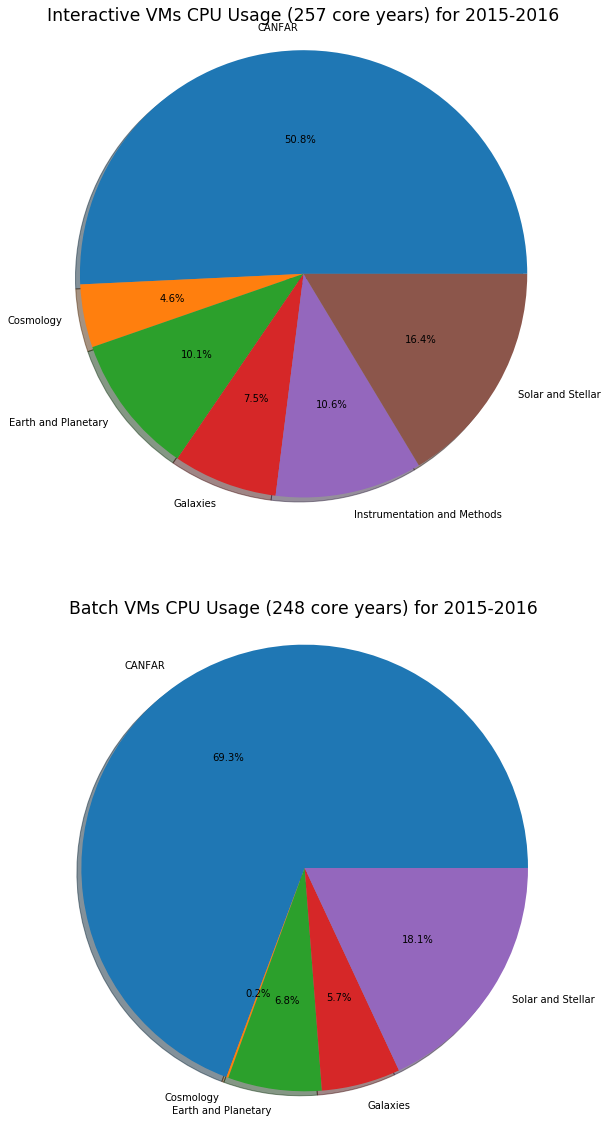

In [287]:
grped_OS = df_OS[ df_OS.Proj != "CANFAR" ].groupby("Categ").sum()["Cpuhours"]
tmp = df.assign(timestamp = df.QDate.astype("datetime64[ms]"))
grped_HTC = tmp[tmp.timestamp >= "2015"].groupby("Categ").sum()["CumulativeSlotTime"]
#print(tmp.loc[tmp.Categ == "Earth and Planetary", "CumulativeSlotTime"].sum())
del tmp
print(grped_OS.sum())
print(grped_HTC.sum())
fig = plt.figure(figsize = (10, 20))
ax = fig.add_subplot(211)
grped_OS.plot(kind = "pie", autopct = '%1.1f%%', shadow = True)
ax.set_ylabel("")
ax.set_title("Interactive VMs CPU Usage (%i core years) for 2015-2016" % (grped_OS.sum() / 24 / 365), size = "xx-large")
ax.axis('equal')
ax = fig.add_subplot(212)
grped_HTC.plot(kind = "pie", autopct = '%1.1f%%', shadow = True)
ax.set_ylabel("")
ax.set_title("Batch VMs CPU Usage (%i core years) for 2015-2016" % (grped_HTC.sum() / 3600 / 24 / 365), size = "xx-large")
ax.axis('equal')
fig.savefig("OpStkPie.png")
plt.show()

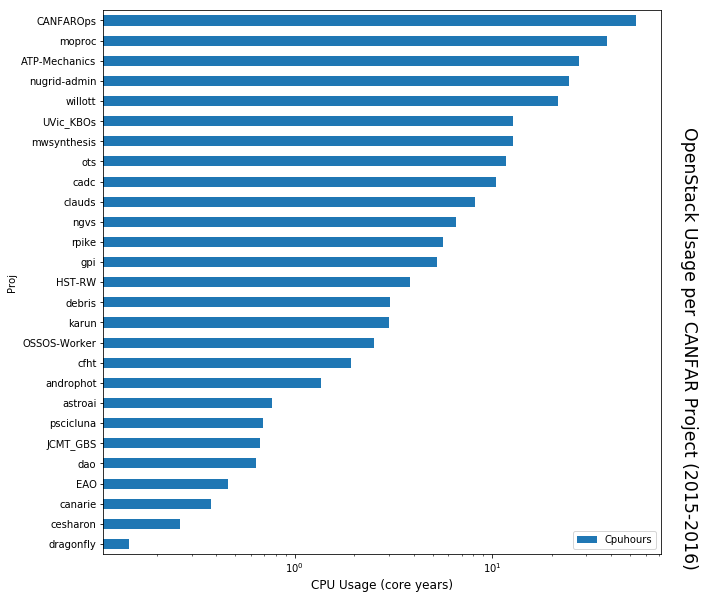

In [288]:
df_OS_CoreYear = df_OS[df_OS.Proj != "CANFAR"][["Proj", "Cpuhours"]].set_index("Proj")
grped_OS_CoreYear = df_OS_CoreYear.groupby(df_OS_CoreYear.index).sum().sort_values(by = "Cpuhours")

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
(grped_OS_CoreYear[grped_OS_CoreYear.Cpuhours > 0] / 24 / 365).plot(kind = "barh", ax = ax, log = True)
ax.set_xlabel("CPU Usage (core years)", size = "large")
ax.set_title("OpenStack Usage per CANFAR Project (2015-2016)", size = "xx-large", x = 1.05, y = 0.75, rotation = -90)
fig.savefig("OpStkCoreYrPerProj.png")
plt.show()

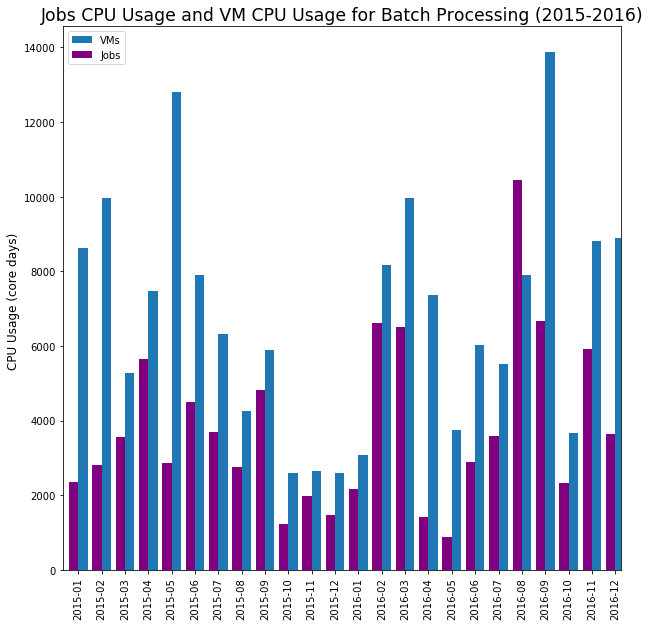

In [289]:
# OpenStack logs, CANFAR project
df_OS_CANFAR = df_OS[(df_OS.Proj == "CANFAR") & (df_OS.Loc == "west") & (df_OS.day < "2017-01-01")]
df_OS_CANFAR = df_OS_CANFAR.set_index("day")
grped_OS_CANFAR = df_OS_CANFAR["Cpuhours"]\
                    .groupby([df_OS_CANFAR.index.year, df_OS_CANFAR.index.month]).sum() / 24
#print(grped_OS_CANFAR)
# HTCondor logs, post OpenStack
df_PostOS = df[["QDate", "CumulativeSlotTime"]].assign(timestamp = df.QDate.astype('datetime64[ms]'))
df_PostOS = df_PostOS[df_PostOS.timestamp >= "2015-01-01"].set_index("timestamp")
grped_PostOS = df_PostOS["CumulativeSlotTime"].groupby([df_PostOS.index.year, df_PostOS.index.month]).sum() / 3600 / 24
#print(grped_PostOS)

fig = plt.figure(figsize=(10,10))
ax = grped_OS_CANFAR.plot(kind = "bar", position = 0, width = 0.4)
grped_PostOS.plot(kind = "bar",  position = 1, ax = ax, color = "purple", width = 0.4)
#ax.set_xlabel("Month", size = "large")
ax.set_ylabel("CPU Usage (core days) ", size = "large")
ax.set_title("Jobs CPU Usage and VM CPU Usage for Batch Processing (2015-2016)", size = "xx-large")
ax.set_xticks(range(len(grped_PostOS)))
ax.set_xticklabels(["%s-%02d" % x for x in grped_PostOS.index.tolist()], rotation = 90)
ax.legend(["VMs", "Jobs"], loc = 2)
fig.savefig("OpStkCANFARCoreDysVMUpTm.png")
plt.show()

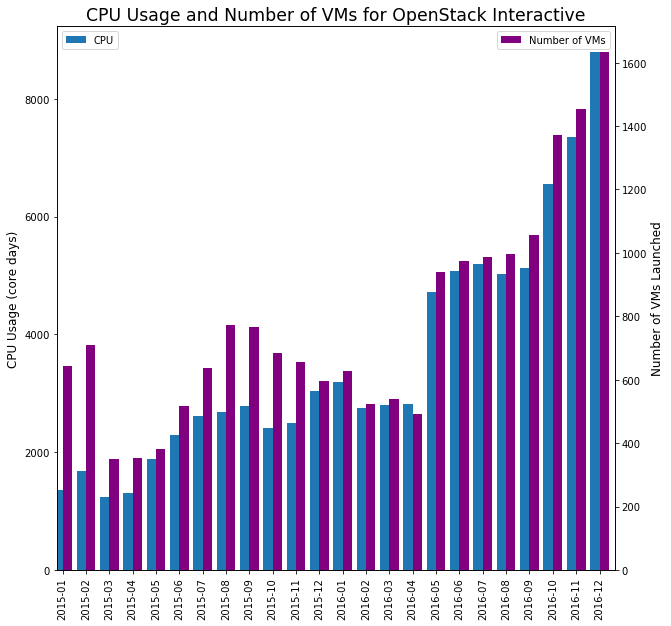

In [290]:
df_OS_nonCANFAR = df_OS[(df_OS.Proj != 'CANFAR') & (df_OS.day < "2017-01-01")]\
                    [["day", "Cpuhours", "Diskgbhours", "Rammbhours", "Nserver"]]
# plot 1    
df_OS_nonCANFAR = df_OS_nonCANFAR.set_index("day")
grped_OS_nonCANFAR = df_OS_nonCANFAR.groupby([df_OS_nonCANFAR.index.year, df_OS_nonCANFAR.index.month])\
                        .sum()[["Cpuhours", "Nserver"]]
#print(grped_OS_nonCANFAR)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
(grped_OS_nonCANFAR["Cpuhours"] / 24).plot(kind = "bar", ax = ax, position = 1, width = 0.4)
#ax.set_xlabel("Operating Month", size = "large")
ax.set_ylabel("CPU Usage (core days)", size = "large")
ax.set_title('CPU Usage and Number of VMs for OpenStack Interactive', size = "xx-large")
ax.legend(["CPU"], loc = 2)
ax2 = ax.twinx()
grped_OS_nonCANFAR["Nserver"].plot(kind = "bar", ax = ax2, position = 0, width = 0.4, color = "purple")
ax2.set_ylabel("Number of VMs Launched", size = "large")
ax2.set_xticks(range(len(grped_OS_nonCANFAR)))
ax2.set_xticklabels(["%s-%02d" % x for x in grped_OS_nonCANFAR.index.tolist()], rotation = 90)
ax2.legend(["Number of VMs"], loc = 1)
# # plot 2
# ax3 = fig.add_subplot(312)
# df_OS_nonCANFAR = df_OS_nonCANFAR.assign(RamPerServer = (df_OS_nonCANFAR.Rammbhours / df_OS_nonCANFAR.Nserver / df_OS_nonCANFAR.Cpuhours / 1024 ))
# df_OS_nonCANFAR = df_OS_nonCANFAR.assign(DskPerServer = (df_OS_nonCANFAR.Diskgbhours / df_OS_nonCANFAR.Nserver / df_OS_nonCANFAR.Cpuhours))
# # grped_OS_nonCANFAR = df_OS_nonCANFAR.groupby([df_OS_nonCANFAR.index.year, df_OS_nonCANFAR.index.month])\
# #                         .mean()[["RamPerServer", "DskPerServer"]]
# grped_OS_nonCANFAR = df_OS_nonCANFAR.groupby([df_OS_nonCANFAR.index.year, df_OS_nonCANFAR.index.month, df_OS_nonCANFAR.index.day])\
#                         .mean()[["RamPerServer", "DskPerServer"]]
# print(grped_OS_nonCANFAR)
# grped_OS_nonCANFAR["RamPerServer"].plot(kind = "bar", ax = ax3, position = 1, width = 0.4, color = "green")
# ax4 = ax3.twinx()
# grped_OS_nonCANFAR["DskPerServer"].plot(kind = "bar", ax = ax4, position = 0, width = 0.4, color = "orange")
# ax3.set_xlabel("Operating Month", size = "large")
# ax3.set_ylabel("RamUsg (GB)", size = "large")
# ax3.set_title('Average RAM/DISK Usage per Server per Day, non-"CANFAR" Projects', size = "xx-large")
# ax3.legend(["RAM"], loc = 2)
# #ax4.set_xticks(range(len(grped_OS_nonCANFAR)))
# ax4.set_ylabel("DiskUsg (GB)", size = "large")
# #ax4.set_xticklabels(["%s-%02d" % x for x in grped_OS_nonCANFAR.index.tolist()], rotation = 90)
# ax4.legend(["DISK"], loc = 1)
# # plot 3
# ax5 = fig.add_subplot(313)
# df_OS_nonCANFAR = df_OS[(df_OS.Proj != 'CANFAR') & (df_OS.day < "2017-01-01")]\
#                     [["Proj", "Cpuhours", "Diskgbhours", "Rammbhours", "Nserver"]].set_index("Proj")
# df_OS_nonCANFAR = df_OS_nonCANFAR.assign(RamPerServer = (df_OS_nonCANFAR.Rammbhours / df_OS_nonCANFAR.Nserver / df_OS_nonCANFAR.Cpuhours / 1024 ))
# df_OS_nonCANFAR = df_OS_nonCANFAR.assign(DskPerServer = (df_OS_nonCANFAR.Diskgbhours / df_OS_nonCANFAR.Nserver / df_OS_nonCANFAR.Cpuhours ))    
# grped_OS_nonCANFAR = df_OS_nonCANFAR.groupby(df_OS_nonCANFAR.index)\
#                         .sum()[["RamPerServer", "DskPerServer"]].sort_values(by = "DskPerServer")
# grped_OS_nonCANFAR = grped_OS_nonCANFAR[grped_OS_nonCANFAR.DskPerServer >= 100]
# print(grped_OS_nonCANFAR)
# grped_OS_nonCANFAR["RamPerServer"].plot(kind = "barh", ax = ax5, position = 1, width = 0.3)
# grped_OS_nonCANFAR["DskPerServer"].plot(kind = "barh", ax = ax5, position = 0, width = 0.3, color = "purple")
# ax5.set_xlabel("Disk/Ram Usage (GB)", size = "large")
# ax5.set_title("Sum of Ram/Disk Usage per Server over Projects", size = "xx-large", x = 1.05, y = 0.9, rotation = -90)
# ax5.legend(["Ram","Dsk"], loc = 4)
# ax6 = ax5.twiny()
# grped_OS_nonCANFAR["Nserver"].plot(kind = "barh", ax = ax6, position = -1, width = 0.3, color = "green")
# ax6.set_xlabel("Number of Servers", size = "large")
fig.savefig("OpStkNonCANFARCoreDysNumVMs.png")
plt.show()

In [309]:
# # plot 2
fig = plt.figure(figsize=(10,10))

ax3 = fig.add_subplot(111)
df_OS_nonCANFAR = df_OS_nonCANFAR.assign(RamPerServer = (df_OS_nonCANFAR.Rammbhours / df_OS_nonCANFAR.Nserver / df_OS_nonCANFAR.Cpuhours / 1024 ))
#df_OS_nonCANFAR = df_OS_nonCANFAR.assign(DskPerServer = (df_OS_nonCANFAR.Diskgbhours / df_OS_nonCANFAR.Nserver / df_OS_nonCANFAR.Cpuhours))
# # grped_OS_nonCANFAR = df_OS_nonCANFAR.groupby([df_OS_nonCANFAR.index.year, df_OS_nonCANFAR.index.month])\
# #                         .mean()[["RamPerServer", "DskPerServer"]]
#grped_OS_nonCANFAR = df_OS_nonCANFAR.groupby([df_OS_nonCANFAR.index.year, df_OS_nonCANFAR.index.month, df_OS_nonCANFAR.index.day])\
#                         .mean()[["RamPerServer", "DskPerServer"]]
#print(grped_OS_nonCANFAR)
#grped_OS_nonCANFAR["RamPerServer"].plot(kind = "bar", ax = ax3, position = 1, width = 0.4, color = "green")
grped_OS_nonCANFAR = df_OS_nonCANFAR.groupby([df_OS_nonCANFAR.index.year, df_OS_nonCANFAR.index.month])\
                        .mean()[["Cpuhours", "Nserver"]]
#print(grped_OS_nonCANFAR)
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111)
(grped_OS_nonCANFAR["Rammbhours"] / 24).plot(kind = "bar", ax = ax, position = 1, width = 0.4)

#ax4 = ax3.twinx()
#grped_OS_nonCANFAR["DskPerServer"].plot(kind = "bar", ax = ax4, position = 0, width = 0.4, color = "orange")
#ax3.set_xlabel("Operating Month", size = "large")
ax3.set_ylabel("Memory Usage (GB)", size = "large")
ax3.set_title('Average Memory Usage per Server', size = "xx-large")
ax2.set_xticks(range(len(grped_OS_nonCANFAR)))
ax2.set_xticklabels(["%s-%02d" % x for x in grped_OS_nonCANFAR.index.tolist()], rotation = 90)
#ax3.legend(["RAM"], loc = 2)
# #ax4.set_xticks(range(len(grped_OS_nonCANFAR)))
# ax4.set_ylabel("DiskUsg (GB)", size = "large")
# #ax4.set_xticklabels(["%s-%02d" % x for x in grped_OS_nonCANFAR.index.tolist()], rotation = 90)
# ax4.legend(["DISK"], loc = 1)
# # plot 3
# ax5 = fig.add_subplot(313)
# df_OS_nonCANFAR = df_OS[(df_OS.Proj != 'CANFAR') & (df_OS.day < "2017-01-01")]\
#                     [["Proj", "Cpuhours", "Diskgbhours", "Rammbhours", "Nserver"]].set_index("Proj")
# df_OS_nonCANFAR = df_OS_nonCANFAR.assign(RamPerServer = (df_OS_nonCANFAR.Rammbhours / df_OS_nonCANFAR.Nserver / df_OS_nonCANFAR.Cpuhours / 1024 ))
# df_OS_nonCANFAR = df_OS_nonCANFAR.assign(DskPerServer = (df_OS_nonCANFAR.Diskgbhours / df_OS_nonCANFAR.Nserver / df_OS_nonCANFAR.Cpuhours ))    
# grped_OS_nonCANFAR = df_OS_nonCANFAR.groupby(df_OS_nonCANFAR.index)\
#                         .sum()[["RamPerServer", "DskPerServer"]].sort_values(by = "DskPerServer")
# grped_OS_nonCANFAR = grped_OS_nonCANFAR[grped_OS_nonCANFAR.DskPerServer >= 100]
# print(grped_OS_nonCANFAR)
# grped_OS_nonCANFAR["RamPerServer"].plot(kind = "barh", ax = ax5, position = 1, width = 0.3)
# grped_OS_nonCANFAR["DskPerServer"].plot(kind = "barh", ax = ax5, position = 0, width = 0.3, color = "purple")
# ax5.set_xlabel("Disk/Ram Usage (GB)", size = "large")
# ax5.set_title("Sum of Ram/Disk Usage per Server over Projects", size = "xx-large", x = 1.05, y = 0.9, rotation = -90)
# ax5.legend(["Ram","Dsk"], loc = 4)
# ax6 = ax5.twiny()
# grped_OS_nonCANFAR["Nserver"].plot(kind = "barh", ax = ax6, position = -1, width = 0.3, color = "green")
# ax6.set_xlabel("Number of Servers", size = "large")
fig.savefig("OpStkNonCANFARRAM.png")
plt.show()

KeyError: 'Rammbhours'

In [132]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path
import mpld3
import re

csv_path = "/data/proc_logs"

DType = {
"timestamp":np.float64,
"service":np.str_,
"user":np.str_,
"success":np.bool_,
"method":np.str_,
"from":np.str_,
"message":np.str_,
"time":np.float64    
}

df_Proc = pd.DataFrame()

for dirpath, dirnames, filenames in os.walk(csv_path):
    for filename in [f for f in filenames if f.endswith(".csv")]:
        f = os.path.join(dirpath, filename)
        tmp = pd.read_csv(f, dtype = DType)
        df_Proc = df_Proc.append(tmp)
del tmp

df_Proc = df_Proc.assign(timestamp = df_Proc.timestamp.astype('datetime64[ms]'))
df_Proc = df_Proc[df_Proc.timestamp < "2017-01-01"]
#print(df_Proc)

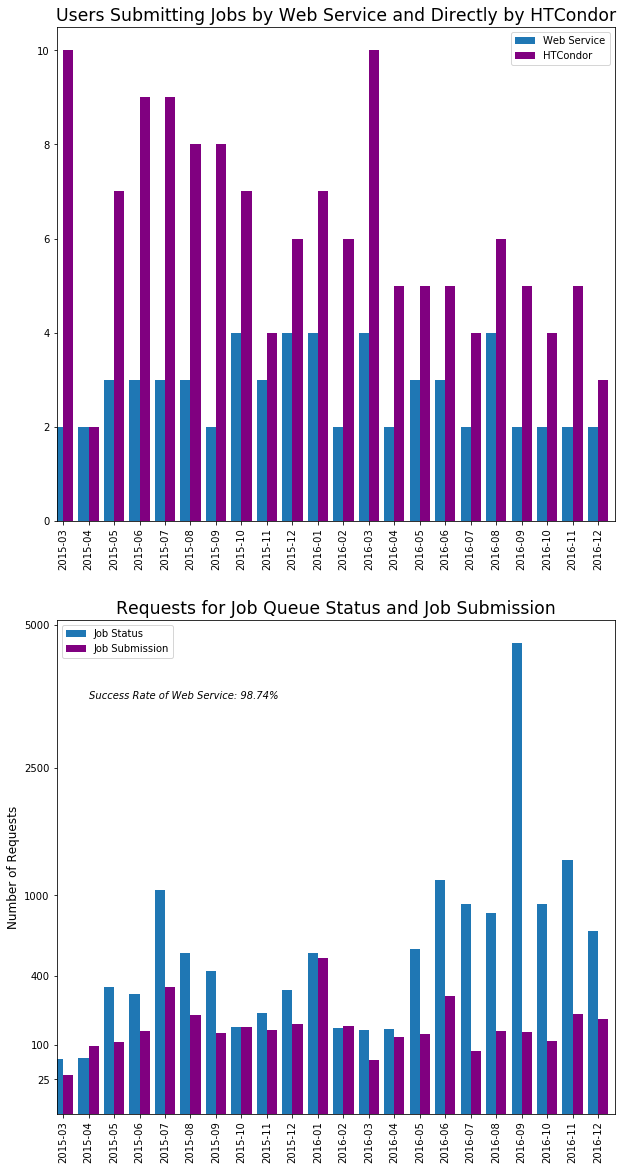

In [291]:
df_Proc = df_Proc.reset_index().set_index("timestamp")
# plot 1
df_Proc_UniUsr = df_Proc[df_Proc.method == "POST"]
grped_Proc_UniUsr = df_Proc_UniUsr.groupby([df_Proc_UniUsr.index.year, df_Proc_UniUsr.index.month])\
                .agg({"user": lambda x: x.nunique()})
#print(grped_Proc_UniUsr)
fig = plt.figure(figsize = (10, 20))
ax = fig.add_subplot(211)
grped_Proc_UniUsr.plot(kind = "bar", ax = ax, position = 1, width = 0.4)
df_Condor_Usr = df[["QDate", "Owner"]]
df_Condor_Usr = df_Condor_Usr.assign(timestamp = df.QDate.astype("datetime64[ms]"))
df_Condor_Usr = df_Condor_Usr[(df_Condor_Usr.timestamp >= "2015-03") & (df_Condor_Usr.timestamp < "2017-01")]\
                    [["timestamp","Owner"]].set_index("timestamp")
grped_Condor_Usr = df_Condor_Usr.groupby([df_Condor_Usr.index.year,df_Condor_Usr.index.month])\
                    .agg({"Owner": lambda x: x.nunique()})
grped_Condor_Usr.plot(kind = "bar", ax = ax, color = "purple", position = 0, width = 0.4)
ax.set_xticks(range(len(grped_Proc_UniUsr)))
ax.set_title("Users Submitting Jobs by Web Service and Directly by HTCondor", size = "xx-large")
ax.set_xticklabels(["%s-%02d" % x for x in grped_Proc_UniUsr.index.tolist()], rotation = 90)

ax.legend(["Web Service", "HTCondor"], loc = 1)
# plt 2
ax2 = fig.add_subplot(212)
df_Proc_Get = df_Proc[df_Proc.method == "GET"]
df_Proc_Post = df_Proc[df_Proc.method == "POST"]
grped_Get = df_Proc_Get["method"].groupby([df_Proc_Get.index.year, df_Proc_Get.index.month]).count().apply(np.sqrt)
grped_Post = df_Proc_Post["method"].groupby([df_Proc_Post.index.year, df_Proc_Post.index.month]).count().apply(np.sqrt)
#print(grped_Get)
#print(grped_Post)
grped_Get.plot(kind = "bar", width = 0.4, position = 1, ax = ax2)
grped_Post.plot(kind = "bar", width = 0.4, position = 0, ax = ax2, color = "purple")
ax2_yticks = [25, 100, 400, 1000, 2500, 5000]
ax2.set_yticks([x for x in np.sqrt(ax2_yticks)])
ax2.set_yticklabels([str(x) for x in ax2_yticks])
ax2.set_xticklabels(["%s-%02d" % x for x in grped_Post.index.tolist()], rotation = 90)
ax2.set_title('Requests for Job Queue Status and Job Submission', size = "xx-large")
ax2.set_ylabel("Number of Requests", size = "large")
ax2.legend(["Job Status", "Job Submission"], loc = 2)
ax2.text(1, 60, "Success Rate of Web Service: %1.2f%%" % (len(df_Proc[df_Proc.success == True]) / len(df_Proc) * 100), style = "italic")
# plt 3
fig.savefig("ProcNumUsrHTCSubs.png")
plt.show()

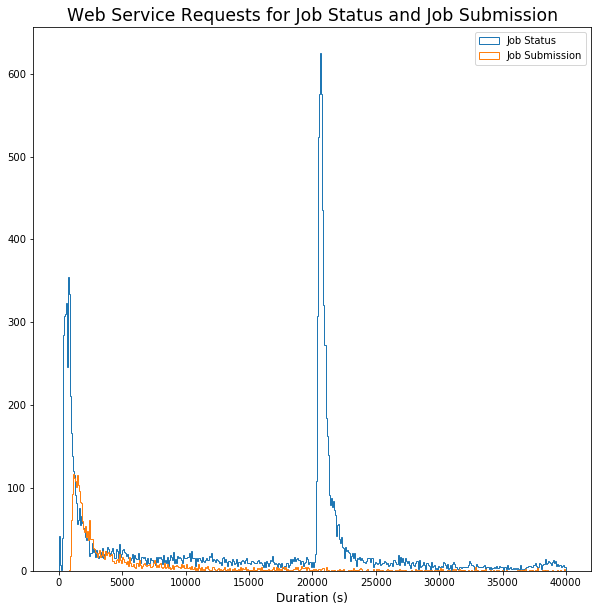

In [300]:
# plt 3
fig = plt.figure(figsize = (10, 10))
ax3 = fig.add_subplot(111)

ax3.hist(df_Proc_Get[df_Proc_Get.message.isnull()]["time"], bins = 500, histtype = "step", range = (0, 40000))
ax3.hist(df_Proc_Post[df_Proc_Post.message.isnull()]["time"], bins = 500, histtype = "step", range = (0, 40000))
ax3.legend(["Job Status", "Job Submission"], loc = 1)
ax3.set_title("Web Service Requests for Job Status and Job Submission", size = "xx-large")
ax3.set_xlabel("Duration (s)", size = "large")
fig.savefig("ProcHistPOSTGET.png")
plt.show()

In [170]:
print("ONE BIG # OF HOW MANY Success = False: %i" % len(df_Proc[df_Proc.success == False]))

ONE BIG # OF HOW MANY Success = False: 243


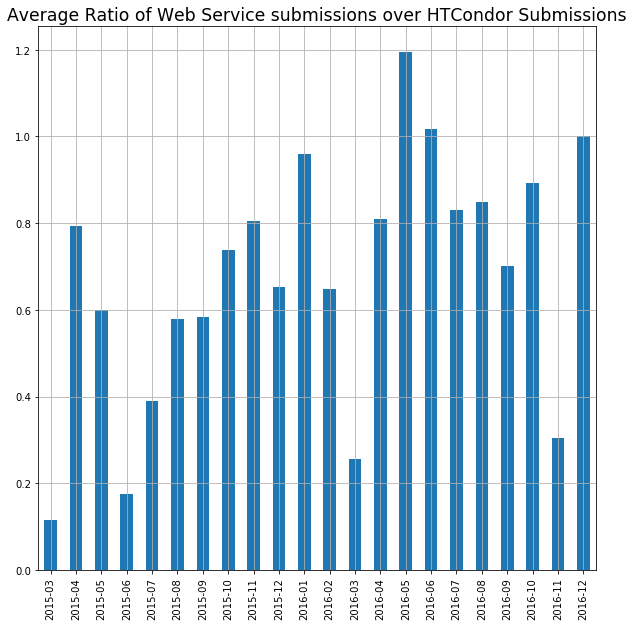

In [292]:
df_Proc_Post = df_Proc[(df_Proc.method == "POST") & (df_Proc.message.isnull()) ] # post and non-null msg only
df_Proc_Post = df_Proc_Post[df_Proc_Post.success == True] # successful request only
grped_Post = df_Proc_Post.groupby([df_Proc_Post.index.year, df_Proc_Post.index.month]).count()
#grped_Post = grped_Post.assign(NumReq = (grped_Post.method - grped_Post.message)) # take out the ones with err msg
# print(grped_Post)
df_UniClstId = df.assign(timestamp = df.QDate.astype("datetime64[ms]"))
df_UniClstId = df_UniClstId[(df_UniClstId.timestamp >= "2015-03") & (df_UniClstId.timestamp < "2017-01")\
                    & (df_UniClstId.ProcId >= 0) & (df_UniClstId.ProcId >= 0)].set_index("timestamp")
grped_UniClstId = df_UniClstId.groupby([df_UniClstId.index.year, df_UniClstId.index.month])\
                    .agg({"ClusterId": lambda x: x.nunique()})    
# print(grped_UniClstId) 

# print(grped_Post.method / grped_UniClstId.ClusterId)

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
(grped_Post.method / grped_UniClstId.ClusterId).plot(kind = "bar", grid = True, ax = ax)
ax.set_xticklabels(["%s-%02d" % x for x in grped_Post.index.tolist()], rotation = 90)
ax.set_title('Average Ratio of Web Service submissions over HTCondor Submissions', size = "xx-large")
fig.savefig("ProcNumPOSTNumHTCSubs.png")
plt.show()